In [43]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          4.1                         
year           2017                        
month          06                          
day            30                          
svn rev        72865                       
language       R                           
version.string R version 3.4.1 (2017-06-30)
nickname       Single Candle               

In [42]:
install.packages('markovchain', dependencies=TRUE, repos='https://cran.r-project.org/src/contrib/Archive')

Installing package into ‘/usr/local/spark-2.3.1-bin-hadoop2.7/R/lib’
(as ‘lib’ is unspecified)
Warning message:
“unable to access index for repository https://cran.r-project.org/src/contrib/Archive/src/contrib:
  cannot open URL 'https://cran.r-project.org/src/contrib/Archive/src/contrib/PACKAGES'”Warning message:
“package ‘markovchain’ is not available (for R version 3.4.1)”

In [39]:
install.packages(c('diagram', 'markovchain'))

Installing packages into ‘/usr/local/spark-2.3.1-bin-hadoop2.7/R/lib’
(as ‘lib’ is unspecified)
Warning message:
“package ‘markovchain’ is not available (for R version 3.4.1)”

In [173]:
library(depmixS4)
library(data.table)
library(ggplot2)

In [265]:
require(gridExtra)

Loading required package: gridExtra


### Occasionally dishonest casino



1. There are 2 types of dice, fare and not fare


Links:

- [S3](https://s3-ap-southeast-1.amazonaws.com/erbuc/files/c893615b-5f1e-422e-833c-10ac70bd39c9.pdf)

- [Good vis examples](https://rpubs.com/JanpuHou/326048)

- [DepMix doc](https://r-forge.r-project.org/scm/viewvc.php/*checkout*/papers/jss/V1/depmixS4.pdf?root=depmix)

$A$ is a transition matrix, first row is for the fair dice, the seconds is not

In [407]:
A <- matrix(c(0.95, 0.05, 0.1, 0.9), nrow=2, byrow = TRUE)
A

0.95,0.05
0.10,0.90


Generate some probabilities

In [408]:
fair_dice <- function() {
    sample(c(1:6), 1, replace=TRUE, prob=rep(1/6, 6))
}

loaded_dice <- function() {
    sample(c(1:6), 1, replace=TRUE, prob=c(rep(1/10,5), 5/10))
}

casino_dice <- function(s) {
    ifelse(s == 1, fair_dice(), loaded_dice())
}

roll_dice <- function(n, A.tr){    
    state = 2
    z <- c(state)
    dice <- c(casino_dice(state))
    vz <- matrix(c(1,0,0,1), nrow = 2, byrow = TRUE)
    for (i in 1:n) {
        p_change <- t(vz[,state]) %*%(A) 
        if (runif(n=1) <= p_change[state]) {            
            z <- c(z,state)            
        } else { 
            state <- ifelse(state==1, 2, 1)
            z <- c(z, state)            
        }
        dice <- c(dice, casino_dice(state))       
    }
    res <- data.table(z=as.factor(z), dice=dice, round=c(1:(n+1)))
    res
}

play <- roll_dice(400, A)

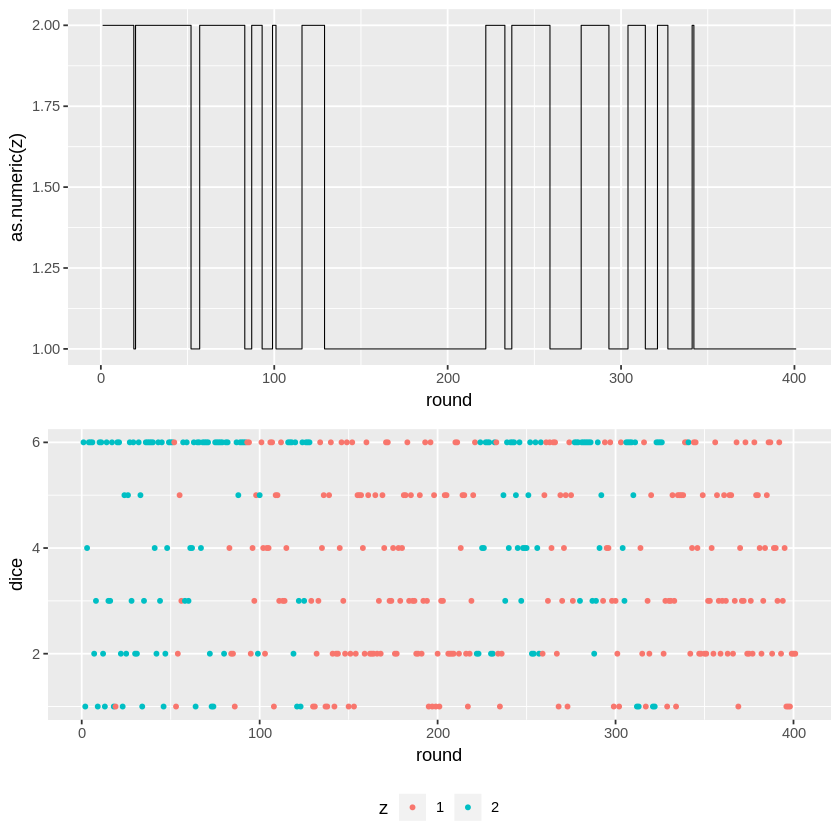

In [409]:
g <- ggplot(data=play) + geom_point(aes(y=dice, x=round, color=z), size=1) + theme(legend.position="bottom")
gz <- ggplot(data=play) + geom_step(aes(y=as.numeric(z), x=round), size=0.3) + theme(legend.position="bottom")
grid.arrange(gz, g)

In [410]:
mod <- depmix(list(dice~1),data=play, nstates=2, family = list(multinomial("identity")))
fm <- fit(mod)
summary(fm)

iteration 0 logLik: -684.7083 
iteration 5 logLik: -684.7036 
iteration 10 logLik: -684.6965 
iteration 15 logLik: -684.6847 
iteration 20 logLik: -684.6663 
iteration 25 logLik: -684.6416 
iteration 30 logLik: -684.6136 
iteration 35 logLik: -684.5847 
iteration 40 logLik: -684.5536 
iteration 45 logLik: -684.5153 
iteration 50 logLik: -684.4597 
iteration 55 logLik: -684.3651 
iteration 60 logLik: -684.1743 
iteration 65 logLik: -683.7046 
iteration 70 logLik: -682.2864 
iteration 75 logLik: -678.4469 
iteration 80 logLik: -675.2278 
iteration 85 logLik: -674.5868 
iteration 90 logLik: -674.4147 
iteration 95 logLik: -674.3532 
iteration 100 logLik: -674.3294 
iteration 105 logLik: -674.3183 
iteration 110 logLik: -674.3121 
iteration 115 logLik: -674.308 
iteration 120 logLik: -674.3053 
iteration 125 logLik: -674.3034 
iteration 130 logLik: -674.302 
iteration 135 logLik: -674.3011 
iteration 140 logLik: -674.3004 
iteration 145 logLik: -674.3 
iteration 150 logLik: -674.2996 
iter

In [414]:
res <- as.data.table(cbind(play, fm@posterior))
res[,state:=ifelse(state==2, 1, 0)]
res[,z:=ifelse(z==2, 1, 0)]

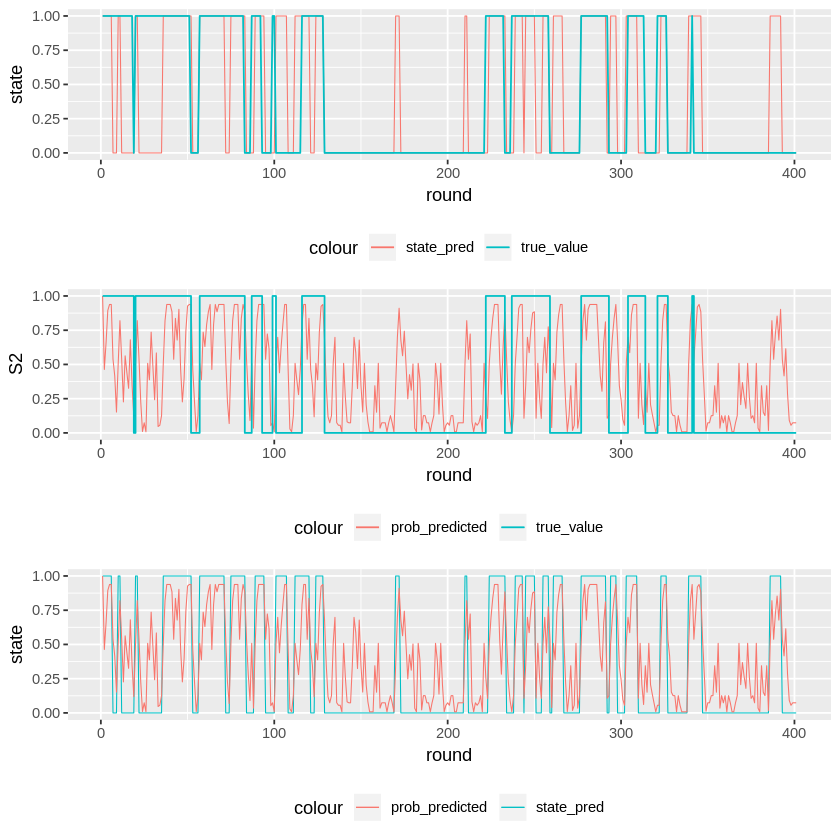

In [415]:
gres <- ggplot(data=res) +
geom_line(aes(x=round, y=S2, color='prob_predicted'), size=0.3) + 
geom_step(aes(y=as.numeric(z), x=round, color='true_value'), size=0.5) +
theme(legend.position="bottom")

gres2 <- ggplot(data=res) +
geom_line(aes(x=round, y=state, color='state_pred'), size=0.3) + 
geom_line(aes(x=round, y=z, color='true_value'), size=0.5) +
theme(legend.position="bottom")

gres3 <- ggplot(data=res) +
geom_line(aes(x=round, y=state, color='state_pred'), size=0.3) + 
geom_line(aes(x=round, y=S2, color='prob_predicted'), size=0.3) + 
theme(legend.position="bottom")

grid.arrange(gres2, gres, gres3)